In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader 
import random
# Seed
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [28]:
data = pd.read_excel('/content/HD_2019_M_2.xlsx')
all_nan = data.columns[data.isnull().sum() == 465].tolist()
data = data.drop(columns = all_nan)
trainset= {}

In [29]:
data

,ID,生日,性別,開始治療日期,HBsAg,Anti-HCV,合併症,PlanDate,透析方式,抗凝劑,...,K (meq/l),離子鈣 (mg/dl),P (mg/dl),URR,Kt/V (Gotch),Kt/V,nPCR,TACurea,Cardiac/thoracic ratio (%),Ca X P (mg2/dL2)
0,5004995,31/11/18,2,1996/8/28,N,N,19-30,20190130.0,3.0,0.0,...,4.8,4.24,4.1,0.87,2.02,2.45,1.65,47.0,0.53,34.77
1,3983367,35/2/15,1,1995/12/11,N,N,13-19-0,20190130.0,3.0,1.0,...,4.3,4.93,4.0,0.75,1.39,1.68,1.46,52.5,0.48,39.44
2,400509,27/12/18,2,1993/3/16,N,N,12-0-25,20190130.0,3.0,1.0,...,2.9,3.97,2.3,0.71,1.25,1.50,0.48,13.5,0.52,18.26
3,3468683,41/2/17,2,1995/7/30,N,N,8-11-12-19-25-0,20190130.0,3.0,2.0,...,4.7,5.12,5.8,0.83,1.76,2.15,1.75,54.5,0.42,59.39
4,2419091,42/12/20,2,1994/12/12,N,N,10-22-30-33-13-19-5-7,20190130.0,3.0,0.0,...,4.3,5.09,4.6,0.77,1.45,1.74,1.44,50.0,0.62,46.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,11895105,30/11/28,1,2018/12/6,N,N,19-22-29-30,20190129.0,3.0,0.0,...,3.6,4.05,5.7,0.73,1.32,1.61,0.85,28.5,NaN,46.17
461,1690080,28/1/24,2,2018/12/29,N,N,NaN,20190129.0,3.0,0.0,...,3.1,3.98,4.5,0.72,1.26,1.42,1.57,61.0,NaN,35.82
462,13944660,51/1/29,1,2019/1/5,N,N,1-25-29-30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
463,3846692,22/2/28,1,2019/1/22,N,N,10-19-22-29-30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def age(date):
    date = date.split('/')
    age = 111-int(date[0])
    return age
def treat_year(date):
    date = date.split('/')
    year = 2019-int(date[0])
    return year

In [4]:
df = data.rename(columns = {'合併症':'comorbidities', '性別':'gender', '離子鈣 (mg/dl)':'Ca', '生日':'birthday', 
    '透析前體重(kg)':'weight', '本次透析時間(min)':'duration', '本次透析前BUN (mg/dl)':'BUN', '兩次透析時間間隔 (min)':'time_interval'})
df['Age'] = df['birthday'].map(age)
df['treatment_year'] = df['開始治療日期'].map(treat_year)
# 合併症因為還不確定空值所以先暫時刪掉，Glucose因為空值太多所以先刪掉, Kt/V (Gotch)適用另一種公式算的先刪掉
df = df.drop(columns = ['本次透析後BUN (mg/dl)', '透析後體重(kg)', '透析器型號', 'PlanDate', 'birthday', '開始治療日期','Glucose[AC] (mg/dl)','Kt/V (Gotch)']) 


In [5]:
#target_col = [col for col in x.columns if '(' in col]
def trim_column(col,df):
  new_col = col.split(' (')[0]
  df = df.rename(columns = {col:new_col})
  return df
col_list = df.filter(like=' (').columns

for i in col_list:
  df = trim_column(i,df)

In [6]:
df = df[df[df.columns[4:15]].isna().sum(axis=1) == 0] # drop parameter contain null value
df = df[df.isna().sum(axis=1)<10] # 病患特徵中有3個人缺值超過10個欄位，這三個人直接刪掉
df = df.drop(396) # drop kt/v is null

In [7]:
def split_comorbidity(x):
  output = []
  x = x.split('-')
  for i in x:
    if i!='0':
      output.append(int(i))
  #x = [int(i) for i in x]
  return output
df['comorbidities'] = df['comorbidities'].map(split_comorbidity)

In [8]:
# 要補空值的欄位有 W.B.C. (x1000/ul), Platelet (x1000/ul), Cardiac/thoracic ratio (%) 都補mean
df['Cardiac/thoracic ratio'] = df['Cardiac/thoracic ratio'].fillna(round(df['Cardiac/thoracic ratio'].mean(),2))
df['W.B.C.'] = df['W.B.C.'].fillna(round(df['W.B.C.'].mean(),1))
df['Platelet'] = df['Platelet'].fillna(round(df['Platelet'].mean(),0))

In [9]:
# split x and y
df = df[df['Kt/V']>1.2]
df = df.reset_index(drop = True)  # drop掉每筆都一樣的column
df = df.drop(columns = ['time_interval','duration','鹼基','Kt/V'])
x = df[df.columns[1:5].tolist()+df.columns[20:].tolist()]


# x
# encoding gender, HBsAg, Anti-HCV
for i in ['HBsAg','Anti-HCV']:
  tempdf = pd.get_dummies(x[i])
  for j in tempdf.columns:
    new_col_name = i+'_'+str(j)
    tempdf = tempdf.rename(columns={j:new_col_name})
  x = pd.concat([x,tempdf],axis=1)
x['gender'] = x['gender'].apply(lambda x:0 if x == 1 else 1)
x = x.drop(columns = ['HBsAg','Anti-HCV'])

# standardize
scaler = StandardScaler().fit(x[x.columns[2:-6]])
x_scaled = scaler.transform(x[x.columns[2:-6]])
x_scaled = pd.DataFrame(data = x_scaled,columns = x.columns[2:-6].tolist())
patient_state = pd.concat([x[x.columns[0]],x[x.columns[-6:]],x_scaled],axis=1)
#patient_state = torch.Tensor(patient_state.to_numpy())


In [10]:
from sklearn.decomposition import PCA

comorbidity_df = pd.DataFrame(data = np.zeros((223,33),dtype=int),columns = ['c'+str(i+1) for i in range(33)])
comorbidity = x[x.columns[1]]

for index,row in enumerate(comorbidity):
  comorbidity_df.loc[index,['c'+str(i) for i in row]] = 1

pca = PCA(n_components=10)
pca.fit(comorbidity_df)
com_pca = pca.transform(comorbidity_df)
com_pca_df = pd.DataFrame(data = com_pca,columns=['com_pca_'+str(i+1) for i in range(10)])
patient_state = pd.concat([x[x.columns[0]],x[x.columns[-6:]],x_scaled,com_pca_df],axis=1)
patient_state = torch.Tensor(patient_state.to_numpy())

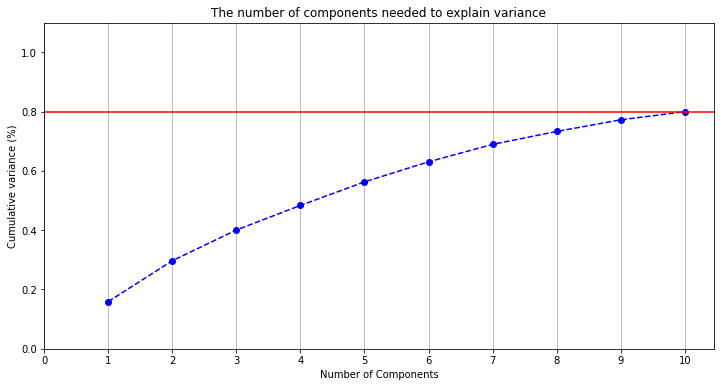

In [ ]:

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 11, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.8, color='r', linestyle='-')
#plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [11]:
y_dict = {}
y = df[df.columns[5:15].tolist()]
for i in ['透析方式','抗凝劑','鉀離子濃度','維持劑量','初劑量','每次透析時間','透析器表面積','鈣離子濃度']:
  le = preprocessing.LabelEncoder()
  le.fit(y[i])
  temp = { i : v for i ,v in enumerate(list(le.classes_))}
  y_dict[i] = temp
  y[i] = le.transform(y[i])

# y
# 預測的時候 除了血液流速和透析流速之外都當作是類別型來預測，只有血液流速和透析流速 output_dim = 1, 其他output_dim = num_class
parameter = {}
label_name = y.columns
# 暫時先用一個參數當作預測目標
for i in y.columns:
  parameter[i] = torch.Tensor(y[i].to_numpy())
unit_dict = { i : len(y[i].value_counts()) for i in y.columns}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
class MyDataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y
        
        
    def __getitem__(self, index):
        self.output = {}
        self.output['patient_state'] = self.x[index]
       
        for i in self.y.keys():
          self.output[i] = self.y[i][index]

        return self.output
    
    def __len__(self):
        return len(self.x)

dataset = MyDataset(patient_state,parameter)
dataloader = DataLoader(dataset, batch_size=4, num_workers=2)
next(iter(dataloader))

{'patient_state': tensor([[ 1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
           0.0000e+00,  0.0000e+00, -3.8166e-01,  2.4859e+00,  2.5522e+00,
           7.2429e-01,  1.3463e-01, -1.5598e+00,  7.3765e-01, -8.9495e-01,
          -3.1283e-02,  4.0742e-01, -3.4826e-01, -7.2731e-01,  2.6678e+00,
           1.4609e+00,  3.0419e-01,  2.7281e-01, -7.8762e-01,  8.4567e-01,
           1.8244e+00, -1.5861e-01, -2.6609e-02, -4.8677e-01,  2.2379e-01,
           6.1707e-02, -3.3614e-01, -5.4707e-01, -9.6112e-02,  3.3610e-03,
          -1.2367e-01],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
           0.0000e+00,  0.0000e+00, -8.7081e-01, -5.0627e-01, -5.8467e-01,
           2.7442e-01, -1.7090e+00, -4.3659e-01,  7.9174e-01, -1.8606e-01,
           9.2000e-01, -3.1826e-01,  1.2068e+00, -8.0793e-01, -1.3023e-02,
           7.8960e-01,  7.6679e-01, -5.2558e-01, -3.8727e-01,  5.2108e-01,
           1.9539e+00, -7.7268e-01, -1.3522e-01,  1.2535e-0

In [ ]:
'''class Embedding(keras.layers.Layer):
  def __init__(self, input_dim, output_dim):
    super(Embedding, self).__init__()
    self.embed_layer = tf.keras.layers.Embedding(input_dim, output_dim)#,input_length=
  
  def call(self, input):
    output = self.embed_layer(input)
    return output'''

'class Embedding(keras.layers.Layer):\n  def __init__(self, input_dim, output_dim):\n    super(Embedding, self).__init__()\n    self.embed_layer = tf.keras.layers.Embedding(input_dim, output_dim)#,input_length=\n  \n  def call(self, input):\n    output = self.embed_layer(input)\n    return output'

In [13]:
class Net(nn.Module):
  def __init__(self, unit_dict):
    super(Net, self).__init__()
    self.layer1 = nn.Linear(36, 64) 
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(64, 32)
    self.layer3 = nn.Linear(32, 16)
    self.branch1 = nn.Linear(16, unit_dict['透析方式'])
    self.branch2 = nn.Linear(16, unit_dict['抗凝劑'])
    self.branch3 = nn.Linear(16, unit_dict['初劑量'])
    self.branch4 = nn.Linear(16, unit_dict['維持劑量'])
    self.branch5 = nn.Linear(16, 1)
    self.branch6 = nn.Linear(16, 1)
    self.branch7 = nn.Linear(16, unit_dict['每次透析時間'])
    self.branch8 = nn.Linear(16, unit_dict['透析器表面積'])
    self.branch9 = nn.Linear(16, unit_dict['鈣離子濃度'])
    self.branch10 = nn.Linear(16, unit_dict['鉀離子濃度'])

  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.layer2(x)
    x = self.relu(x)
    x = self.layer3(x)
    label1 = self.branch1(x)
    label2 = self.branch2(x)
    label3 = self.branch3(x)
    label4 = self.branch4(x)
    label5 = self.branch5(x)
    label6 = self.branch6(x)
    label7 = self.branch7(x)
    label8 = self.branch8(x)
    label9 = self.branch9(x)
    label10 = self.branch10(x)

    return {'透析方式' : label1, '抗凝劑' : label2, '初劑量' : label3, '維持劑量' : label4, '血液流速' : label5, 
          '透析液流速' : label6, '每次透析時間' : label7, '透析器表面積' : label8, '鈣離子濃度' : label9, '鉀離子濃度' : label10}
model = Net(unit_dict)
model_uncertainty = Net(unit_dict)

In [ ]:
print(model)

Net(
  (layer1): Linear(in_features=36, out_features=64, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (branch1): Linear(in_features=16, out_features=4, bias=True)
  (branch2): Linear(in_features=16, out_features=3, bias=True)
  (branch3): Linear(in_features=16, out_features=10, bias=True)
  (branch4): Linear(in_features=16, out_features=10, bias=True)
  (branch5): Linear(in_features=16, out_features=1, bias=True)
  (branch6): Linear(in_features=16, out_features=1, bias=True)
  (branch7): Linear(in_features=16, out_features=6, bias=True)
  (branch8): Linear(in_features=16, out_features=7, bias=True)
  (branch9): Linear(in_features=16, out_features=3, bias=True)
  (branch10): Linear(in_features=16, out_features=2, bias=True)
)


In [ ]:
[p for p in model.parameters()][0],[p for p in model_uncertainty.parameters()][0]

(Parameter containing:
 tensor([[-0.1372, -0.1227, -0.0642,  ..., -0.1561, -0.0973,  0.1433],
         [ 0.0744,  0.0808,  0.0088,  ..., -0.0611,  0.0655,  0.1381],
         [ 0.1450,  0.1471,  0.0332,  ..., -0.1286, -0.0092,  0.0250],
         ...,
         [-0.0252, -0.0945,  0.0877,  ..., -0.0229,  0.0493, -0.0309],
         [-0.1663,  0.1172,  0.1651,  ...,  0.1019, -0.0240, -0.0947],
         [ 0.1333,  0.0775,  0.0475,  ...,  0.1016, -0.1579, -0.1493]],
        requires_grad=True), Parameter containing:
 tensor([[-0.1476,  0.0467,  0.0112,  ..., -0.1041,  0.0288, -0.0480],
         [ 0.1398, -0.0249, -0.1217,  ...,  0.1665,  0.1464,  0.0958],
         [ 0.0857,  0.0660, -0.0292,  ..., -0.0463, -0.0213, -0.0460],
         ...,
         [ 0.1165, -0.0849, -0.1357,  ...,  0.0088, -0.0474,  0.0411],
         [ 0.1318, -0.1529,  0.1658,  ..., -0.1593,  0.0316,  0.1208],
         [ 0.1477, -0.1357,  0.1287,  ...,  0.1129, -0.0271, -0.1483]],
        requires_grad=True))

In [14]:
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.MSELoss()
criterion3 = nn.L1Loss()
loss_func = {'categorical' : criterion1 ,'continuous' : criterion2, 'continuous1' : criterion3}
log_var_dict = {i : torch.zeros((1,), requires_grad=True) for i in y.columns}

params = ([p for p in model_uncertainty.parameters()])
params += [ i for i in log_var_dict.values()]
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer_uncertainty = torch.optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
print(torch.exp(log_var_dict['透析方式'])**0.5, torch.exp(log_var_dict['抗凝劑'])**0.5)

tensor([1.], grad_fn=<PowBackward0>) tensor([1.], grad_fn=<PowBackward0>)


In [15]:
def criterion(y_pred, y_true, loss_func, continuous):
  loss = 0
  if continuous == True:
    loss_value = loss_func(y_pred,y_true)
  else:
    loss_value = loss_func(y_pred,y_true.squeeze().type(torch.LongTensor))
  return loss_value

def criterion_uncertainty(y_pred, y_true, log_vars, loss_func, continuous):
  loss = 0
  precision = torch.exp(-log_vars)
  if continuous == True:
    loss_value = loss_func(y_pred,y_true)
  else:
    loss_value = loss_func(y_pred,y_true.squeeze().type(torch.LongTensor))

  loss = torch.sum(precision * loss_value + log_vars, -1)
  return loss

In [16]:
loss_list1 = []
# baseline
for epoch in range(100):
    train_loss = 0.0
    # train the model #
    model.train()
    for index, dataset in enumerate(dataloader):
        loss = 0
        patient_state = dataset['patient_state']
        # zero the parameter gradients
        optimizer.zero_grad()
        output=model(patient_state)
        
        for i in list(dataset.keys())[1:]:
          label = dataset[i]
          label_hat = output[i]
          #log_var = log_var_dict[i]
          if i == '血液流速' or i == '透析液流速':
            #label_hat = label_hat.squeeze()
            loss += criterion(label_hat,label,loss_func['continuous'],True)
          else:
            loss += criterion(label_hat,label,loss_func['categorical'],False)
        loss = torch.mean(loss)
        
    
        # back prop
        loss.backward() 
        # grad
        optimizer.step()
        #train_loss = train_loss + ((1 / (index + 1)) * (loss.data - train_loss))
        if index % 20 == 0:
            loss_list1.append(loss.item())
            print('Epoch %d, Batch %d trainloss: %.6f' %
              (epoch, index + 1, loss))
    

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Batch 1 trainloss: 307067.468750
Epoch 0, Batch 21 trainloss: 225223.312500
Epoch 0, Batch 41 trainloss: 40888.335938


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Batch 1 trainloss: 143086.546875
Epoch 1, Batch 21 trainloss: 7476.962402
Epoch 1, Batch 41 trainloss: 18556.773438
Epoch 2, Batch 1 trainloss: 62971.132812
Epoch 2, Batch 21 trainloss: 4161.325195
Epoch 2, Batch 41 trainloss: 7563.540527
Epoch 3, Batch 1 trainloss: 24281.513672
Epoch 3, Batch 21 trainloss: 3461.601562
Epoch 3, Batch 41 trainloss: 5031.646973
Epoch 4, Batch 1 trainloss: 10178.065430
Epoch 4, Batch 21 trainloss: 2956.205566
Epoch 4, Batch 41 trainloss: 3868.209717
Epoch 5, Batch 1 trainloss: 5377.435547
Epoch 5, Batch 21 trainloss: 2801.317627
Epoch 5, Batch 41 trainloss: 3325.409180
Epoch 6, Batch 1 trainloss: 3410.627686
Epoch 6, Batch 21 trainloss: 2679.203613
Epoch 6, Batch 41 trainloss: 3057.757324
Epoch 7, Batch 1 trainloss: 2573.331299
Epoch 7, Batch 21 trainloss: 2615.528076
Epoch 7, Batch 41 trainloss: 2963.184326
Epoch 8, Batch 1 trainloss: 2145.748779
Epoch 8, Batch 21 trainloss: 2562.126953
Epoch 8, Batch 41 trainloss: 2856.154297
Epoch 9, Batch 1 t

In [17]:
loss_list2 = []
# uncertainty
for epoch in range(100):
    train_loss = 0.0
    # train the model #
    model_uncertainty.train()
    for index, dataset in enumerate(dataloader):
        loss = 0
        patient_state = dataset['patient_state']
        # zero the parameter gradients
        optimizer_uncertainty.zero_grad()
        output=model_uncertainty(patient_state)
        
        for i in list(dataset.keys())[1:]:
          label = dataset[i]
          label_hat = output[i]
          log_var = log_var_dict[i]
          if i == '血液流速' or i == '透析液流速':
            #label_hat = label_hat.squeeze()
            loss += criterion_uncertainty(label_hat,label,log_var,loss_func['continuous'],True)
          else:
            loss += criterion_uncertainty(label_hat,label,log_var,loss_func['categorical'],False)

        loss = torch.mean(loss)
        
        # back prop
        loss.backward() 
        # grad
        optimizer_uncertainty.step()
        #train_loss = train_loss + ((1 / (index + 1)) * (loss.data - train_loss))
        if index % 20 == 0:
            loss_list2.append(loss.item())
            print('Epoch %d, Batch %d trainloss: %.6f' %
              (epoch, index + 1, loss))
        


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Batch 1 trainloss: 307427.531250
Epoch 0, Batch 21 trainloss: 220356.859375
Epoch 0, Batch 41 trainloss: 29861.261719


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Batch 1 trainloss: 89523.859375
Epoch 1, Batch 21 trainloss: 3561.317627
Epoch 1, Batch 41 trainloss: 10534.440430
Epoch 2, Batch 1 trainloss: 14471.634766
Epoch 2, Batch 21 trainloss: 2385.642334
Epoch 2, Batch 41 trainloss: 4295.858398
Epoch 3, Batch 1 trainloss: 5868.927734
Epoch 3, Batch 21 trainloss: 2123.346680
Epoch 3, Batch 41 trainloss: 2232.481201
Epoch 4, Batch 1 trainloss: 3624.702148
Epoch 4, Batch 21 trainloss: 1819.967529
Epoch 4, Batch 41 trainloss: 1643.954956
Epoch 5, Batch 1 trainloss: 2261.388672
Epoch 5, Batch 21 trainloss: 1683.132446
Epoch 5, Batch 41 trainloss: 1498.036255
Epoch 6, Batch 1 trainloss: 1404.989868
Epoch 6, Batch 21 trainloss: 1612.477783
Epoch 6, Batch 41 trainloss: 1430.348999
Epoch 7, Batch 1 trainloss: 966.078308
Epoch 7, Batch 21 trainloss: 1553.796631
Epoch 7, Batch 41 trainloss: 1370.442871
Epoch 8, Batch 1 trainloss: 777.816406
Epoch 8, Batch 21 trainloss: 1497.555420
Epoch 8, Batch 41 trainloss: 1343.573486
Epoch 9, Batch 1 trainl

In [19]:
import pickle
with open('losslist.pkl', 'rb') as f:
  loss_list3 = pickle.load(f)

baseline_loss = loss_list1[2::3]
uncertainty_loss = loss_list2[2::3]
gradnorm_loss = loss_list3[2::3]
training_loss = pd.DataFrame(columns=['baseline', 'uncertainty', 'gradnorm'])
training_loss['baseline'] = baseline_loss
training_loss['uncertainty'] = uncertainty_loss
training_loss['gradnorm'] = gradnorm_loss

In [27]:
training_loss.loc[90:]

,baseline,uncertainty,gradnorm
90,1482.713623,242.036255,237.423752
91,1454.393555,283.975220,237.541168
92,1484.026489,315.955536,237.652802
93,1523.307861,280.587982,237.758759
94,1628.236572,200.195877,237.859406
95,1661.528564,118.599495,237.955109
96,1644.606567,80.044708,238.045731
97,2109.496582,83.122284,238.132034
98,1891.600464,90.653694,238.213745
99,2494.294922,98.826149,238.291168


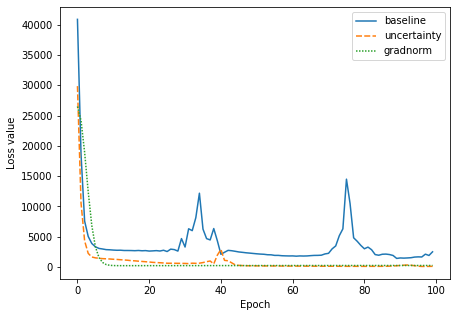

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
sns.lineplot(data=training_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.show()

In [ ]:
print(torch.exp(log_var_dict['透析方式'])**0.5, torch.exp(log_var_dict['抗凝劑'])**0.5)

tensor([0.9751], grad_fn=<PowBackward0>) tensor([1.0539], grad_fn=<PowBackward0>)


In [ ]:
# testtttttttttttttttttt

class Net2(nn.Module):
  def __init__(self, unit_dict):
    super(Net2, self).__init__()
    self.layer1 = nn.Linear(25, 64) 
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(64, 32)
    
    self.branch5 = nn.Linear(32, 1)
    self.branch6 = nn.Linear(32, 1)
    
  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.layer2(x)
    
    label5 = self.branch5(x)
    label6 = self.branch6(x)
    

    return {'血液流速' : label5, '透析液流速' : label6}
model2 = Net2(unit_dict)

In [ ]:
def criteriontest(y_pred, y_true, log_vars, loss_func):
  loss = 0
  precision = torch.exp(-log_vars)
  loss_value = loss_func(y_pred,y_true.squeeze().type(torch.LongTensor))
  loss = torch.sum(precision * loss_value + log_vars, -1)
  return loss

In [ ]:
import torch.nn.functional as F
for epoch in range(1, 10):
    train_loss = 0.0
    # train the model #
    model2.train()
    for index, dataset in enumerate(dataloader):
        loss = 0
        patient_state = dataset['patient_state']
        # zero the parameter gradients
        optimizer.zero_grad()
        output=model2(patient_state)
        
        for i in list(dataset.keys())[5:7]:
          label = dataset[i]
          label_hat = output[i]
          log_var = log_var_dict[i]
          if i == '血液流速' or i == '透析液流速':
            #label_hat = label_hat.squeeze()
            
            #print(label,label_hat)
            loss += criteriontest(label_hat,label,log_var,loss_func['continuous1'])
            print(loss)
          else:
            loss += criteriontest(label_hat,label,log_var,loss_func['categorical'])

        loss = torch.mean(loss)
        
        # back prop
        loss.backward() 
        # grad
        optimizer.step()
        train_loss = train_loss + ((1 / (index + 1)) * (loss.data - train_loss))
        if index % 20 == 0:
            print('Epoch %d, Batch %d trainloss: %.6f loss: %.6f' %
              (epoch, index + 1, train_loss, loss))
        


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor(112.0746, grad_fn=<AddBackward0>)
tensor(335.0180, grad_fn=<AddBackward0>)
Epoch 1, Batch 1 trainloss: 335.017975 loss: 335.017975
tensor(120.5393, grad_fn=<AddBackward0>)
tensor(345.6575, grad_fn=<AddBackward0>)
tensor(103.7015, grad_fn=<AddBackward0>)
tensor(333.3466, grad_fn=<AddBackward0>)
tensor(131.2315, grad_fn=<AddBackward0>)
tensor(356.4425, grad_fn=<AddBackward0>)
tensor(119.1302, grad_fn=<AddBackward0>)
tensor(341.0171, grad_fn=<AddBackward0>)
tensor(120.8108, grad_fn=<AddBackward0>)
tensor(345.5430, grad_fn=<AddBackward0>)
tensor(129.9182, grad_fn=<AddBackward0>)
tensor(354.4366, grad_fn=<AddBackward0>)
tensor(120.9556, grad_fn=<AddBackward0>)
tensor(345.3024, grad_fn=<AddBackward0>)
tensor(122.0823, grad_fn=<AddBackward0>)
tensor(348.1743, grad_fn=<AddBackward0>)
tensor(138.6451, grad_fn=<AddBackward0>)
tensor(361.4201, grad_fn=<AddBackward0>)
tensor(139.1949, grad_fn=<AddBackward0>)
tensor(363.1295, grad_fn=<AddBackward0>)
tensor(125.1925, grad_fn=<AddBackward0>)
t

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor(106.9309, grad_fn=<AddBackward0>)
tensor(319.5689, grad_fn=<AddBackward0>)
Epoch 2, Batch 1 trainloss: 319.568909 loss: 319.568909
tensor(115.0036, grad_fn=<AddBackward0>)
tensor(329.7206, grad_fn=<AddBackward0>)
tensor(98.9535, grad_fn=<AddBackward0>)
tensor(317.9923, grad_fn=<AddBackward0>)
tensor(125.2035, grad_fn=<AddBackward0>)
tensor(340.0201, grad_fn=<AddBackward0>)
tensor(113.6688, grad_fn=<AddBackward0>)
tensor(325.3215, grad_fn=<AddBackward0>)
tensor(115.2740, grad_fn=<AddBackward0>)
tensor(329.6452, grad_fn=<AddBackward0>)
tensor(123.9608, grad_fn=<AddBackward0>)
tensor(338.1336, grad_fn=<AddBackward0>)
tensor(115.4179, grad_fn=<AddBackward0>)
tensor(329.4327, grad_fn=<AddBackward0>)
tensor(116.4953, grad_fn=<AddBackward0>)
tensor(332.1797, grad_fn=<AddBackward0>)
tensor(132.2918, grad_fn=<AddBackward0>)
tensor(344.8186, grad_fn=<AddBackward0>)
tensor(132.8195, grad_fn=<AddBackward0>)
tensor(346.4576, grad_fn=<AddBackward0>)
tensor(119.4702, grad_fn=<AddBackward0>)
te

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
x <- seq(0, 2*pi, length.out=50)
x

 [1] 0.0000000 0.1282283 0.2564565 0.3846848 0.5129131 0.6411414 0.7693696
 [8] 0.8975979 1.0258262 1.1540544 1.2822827 1.4105110 1.5387393 1.6669675
[15] 1.7951958 1.9234241 2.0516523 2.1798806 2.3081089 2.4363372 2.5645654
[22] 2.6927937 2.8210220 2.9492502 3.0774785 3.2057068 3.3339351 3.4621633
[29] 3.5903916 3.7186199 3.8468481 3.9750764 4.1033047 4.2315330 4.3597612
[36] 4.4879895 4.6162178 4.7444460 4.8726743 5.0009026 5.1291309 5.2573591
[43] 5.3855874 5.5138157 5.6420439 5.7702722 5.8985005 6.0267288 6.1549570
[50] 6.2831853


In [ ]:
%%R
CData <- readRDS("C.Diagnosis_AllClean.rds") %>% ungroup
CData

# A tibble: 159,511 × 16
   LOC   IDCODE   CNRSEQ Re.Ty FISTRECTYPE FISTRECDATE TMRPRMYST CANCERKD SYMOGN
   <chr> <chr>    <chr>  <chr> <chr>       <chr>       <chr>     <chr>    <chr> 
 1 2     002865E… 02     META  70          00000000    C185      大腸直…  0     
 2 3     00C2255… 01     META  70          00000000    C739      甲狀癌   0     
 3 3     011DB24… 01     META  70          00000000    C220      肝癌     0     
 4 6     0181DE7… 01     NO    00          00000000    C209      大腸直…  0     
 5 2     019E95D… 01     META  70          00000000    C220      肝癌     0     
 6 2     01B3044… 01     NO    00          00000000    C508      乳癌     2     
 7 2     01B3044… 02     NO    00          00000000    C504      乳癌     1     
 8 3     01B3044… 02     NO    00          00000000    C508      乳癌     1     
 9 6     01F26EB… 01     META  70          00000000    C343      肺癌     1     
10 3     0235BEE… 01     NO    00          00000000    C508      乳癌     2     
# … with 159,501 more rows